Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


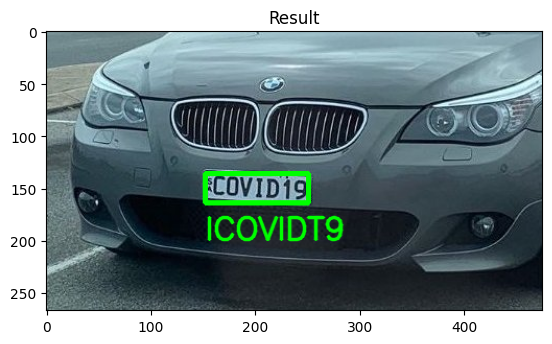

In [1]:
import cv2
import numpy as np
import imutils
import easyocr
import pickle
import os


# Read the image
img = cv2.imread('S:/COLLEGE/PROJECTS/Drivein/image2.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Bilateral filter for noise reduction
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

# Edge detection using Canny
edged = cv2.Canny(bfilter, 30, 200)

# Find contours in the edged image
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
location = None

# Loop over the contours
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

# Create a mask
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

# Find bounding box coordinates
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))

# Crop the image
cropped_image = gray[x1:x2 + 1, y1:y2 + 1]

# Save the cropped image
cv2.imwrite('S:/COLLEGE/PROJECTS/Drivein/cropped_image.jpg', cropped_image)

# OCR using easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
text = result[0][-2]

# Draw the result on the original image
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(location[0][0][0], location[1][0][1] + 60),
                  fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 3)

# Save the easyocr.Reader model using pickle
model_save_path = os.path.join(os.path.expanduser('~'), 'S:/COLLEGE/PROJECTS/Drivein', 'easyocr_model.pkl')
with open(model_save_path, 'wb') as model_file:
    pickle.dump(reader, model_file)

# Display the result using matplotlib
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.title('Result')
plt.show()
